In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc

In [84]:
from sklearn.inspection import permutation_importance, plot_partial_dependence, partial_dependence

In [3]:
import itertools

In [4]:
df = pd.read_csv('processed_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198538 entries, 0 to 198537
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       198538 non-null  int64  
 1   backers_count            198538 non-null  int64  
 2   category                 198538 non-null  object 
 3   country                  198538 non-null  object 
 4   created_at               198538 non-null  object 
 5   deadline                 198538 non-null  object 
 6   is_starrable             198538 non-null  bool   
 7   launched_at              198538 non-null  object 
 8   name                     198538 non-null  object 
 9   staff_pick               198538 non-null  bool   
 10  state                    198538 non-null  object 
 11  usd_pledged              198538 non-null  float64
 12  sub_category             191366 non-null  object 
 13  pledge_per_backer        186173 non-null  float64
 14  usd_

In [6]:
df.columns

Index(['id', 'backers_count', 'category', 'country', 'created_at', 'deadline',
       'is_starrable', 'launched_at', 'name', 'staff_pick', 'state',
       'usd_pledged', 'sub_category', 'pledge_per_backer', 'usd_goal',
       'creation_to_launch_days', 'campaign_days', 'launch_day',
       'deadline_day', 'launch_month', 'deadline_month', 'launch_time',
       'deadline_time', 'clean_text'],
      dtype='object')

In [7]:
df.shape

(198538, 24)

## Preparing target and features

In [8]:
# Dropping columns and creating new dataframe
df_transformed = df.drop(['id', 'name', 'backers_count', 'created_at', 'deadline', 'is_starrable', 
                          'launched_at', 'usd_pledged', 'sub_category', 'pledge_per_backer',
                         'launch_day', 'deadline_day', 'launch_month', 'deadline_month',
                         'launch_time', 'deadline_time'], axis=1)
df_transformed.head()

,category,country,staff_pick,state,usd_goal,creation_to_launch_days,campaign_days,clean_text
0,crafts,US,False,failed,1000.00,1,30,look donations feedback ideas wood work start ...
1,comics,US,True,successful,20000.00,115,30,logan mcbride magical girl destiny shes yearol...
2,crafts,DE,True,successful,2847.66,8,24,wonderful popup christmas card open greet card...
3,crafts,CA,False,successful,75.41,7,30,hi everyone love animals love crochet want com...
4,design,US,False,successful,7500.00,777,40,slim earthfriendly hangers innovative notch el...


In [9]:
df_transformed['state'] = df_transformed['state'].replace({'failed': 0, 'successful': 1})

In [10]:
# Converting boolean features to string to include them in one-hot encoding
df_transformed['staff_pick'] = df_transformed['staff_pick'].astype(str)

In [11]:
# Creating dummy variables
df_transformed = pd.get_dummies(df_transformed, columns=['staff_pick', 'category', 'country'], dummy_na=True)

In [12]:
df_transformed.head()

,state,usd_goal,creation_to_launch_days,campaign_days,clean_text,staff_pick_False,staff_pick_True,staff_pick_nan,category_art,category_comics,...,country_MX,country_NL,country_NO,country_NZ,country_PL,country_SE,country_SG,country_SI,country_US,country_nan
0,0,1000.00,1,30,look donations feedback ideas wood work start ...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,20000.00,115,30,logan mcbride magical girl destiny shes yearol...,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1,2847.66,8,24,wonderful popup christmas card open greet card...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,75.41,7,30,hi everyone love animals love crochet want com...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,7500.00,777,40,slim earthfriendly hangers innovative notch el...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [13]:
y = df_transformed['state']

In [14]:
X = df_transformed.drop('state', axis=1)

### NLP

In [15]:
corpus = df_transformed['clean_text'].values.tolist()

In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.001)
X_tfidf = vectorizer.fit_transform(corpus)

In [17]:
X_tfidf.shape

(198538, 1928)

In [18]:
X_tfidf = pd.DataFrame(X_tfidf.toarray()) #convert to dataframe for concatenation

In [19]:
X = X.drop(columns=['clean_text'])

In [20]:
X_all_feat = pd.concat([X, X_tfidf], axis = 1)

## Baseline Models

In [37]:
# Splitting Dataset into train and test set 
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(
    X_tfidf, y, test_size=0.25, random_state=42)

In [21]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(
    X_all_feat, y, test_size=0.25, random_state=42)

### logistic regression

In [73]:
scaler = StandardScaler()
X_unscaled = pd.DataFrame(scaler.fit_transform(X_all_feat), columns=list(X_all_feat.columns))
X_unscaled.head()

,usd_goal,creation_to_launch_days,campaign_days,staff_pick_False,staff_pick_True,staff_pick_nan,category_art,category_comics,category_crafts,category_dance,...,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927
0,-0.033070,-0.347656,-0.223582,0.410399,-0.410399,0.0,-0.34255,-0.215935,5.057826,-0.145428,...,-0.122968,-0.035378,-0.035922,-0.045409,-0.060071,-0.05217,-0.040496,-0.034216,-0.058353,-0.040664
1,-0.014498,0.466008,-0.223582,-2.436653,2.436653,0.0,-0.34255,4.631021,-0.197713,-0.145428,...,-0.122968,-0.035378,-0.035922,-0.045409,-0.060071,-0.05217,-0.040496,-0.034216,-0.058353,-0.040664
2,-0.031264,-0.297695,-0.717889,-2.436653,2.436653,0.0,-0.34255,-0.215935,5.057826,-0.145428,...,-0.122968,-0.035378,-0.035922,-0.045409,-0.060071,-0.05217,-0.040496,-0.034216,-0.058353,-0.040664
3,-0.033973,-0.304832,-0.223582,0.410399,-0.410399,0.0,-0.34255,-0.215935,5.057826,-0.145428,...,-0.122968,-0.035378,-0.035922,-0.045409,-0.060071,-0.05217,-0.040496,-0.034216,-0.058353,-0.040664
4,-0.026716,5.190973,0.600264,0.410399,-0.410399,0.0,-0.34255,-0.215935,-0.197713,-0.145428,...,-0.122968,-0.035378,-0.035922,-0.045409,-0.060071,-0.05217,-0.040496,-0.034216,-0.058353,-0.040664


In [74]:
# Splitting Dataset into train and test set 
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_unscaled, y, test_size=0.25, random_state=42)

In [75]:
# Fitting a logistic regression model with default parameters
logreg = LogisticRegression()
logreg.fit(X_train_s,y_train_s)

/home/main/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [76]:
# Making predictions
y_hat_train = logreg.predict(X_train_s)
y_hat_logreg = logreg.predict(X_test_s)

In [83]:
# Logistic regression scores
print("Logistic regression score for test set:", round(logreg.score(X_test_s, y_test_s),5))
print("\nClassification report:")
print(classification_report(y_test_s, y_hat_logreg))

Logistic regression score for test set: 0.76053

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65     18173
           1       0.79      0.85      0.82     31462

    accuracy                           0.76     49635
   macro avg       0.74      0.73      0.73     49635
weighted avg       0.76      0.76      0.76     49635



/home/main/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUC: 0.82609


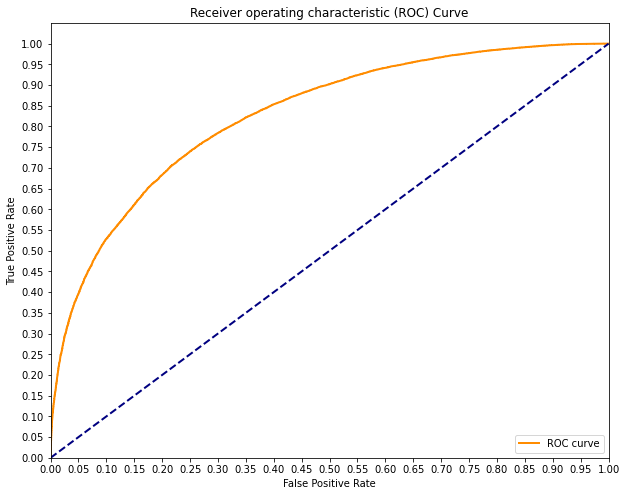

In [82]:
# Plotting the AUC-ROC
y_score = logreg.fit(X_train_s, y_train_s).decision_function(X_test_s)
fpr, tpr, thresholds = roc_curve(y_test_s, y_score)

print('AUC:', round(auc(fpr, tpr),5))

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

In [ ]:
# Confusion matrix
plot_cf(y_test_s, y_hat_logreg)

In [ ]:
# Your data
data = logreg.coef_
labels = X.columns

In [ ]:
logreg.coef_.shape

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(np.arange(30), data.ravel()[:30])
ax.set_xticks(np.arange(30))
ax.set_xticklabels(labels[:30], rotation=90)
ax.set_xticks(np.arange(30))
ax.set_ylim([-1,1]);
#high coefficients: usd goal, categories of comics, games, and music

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(np.arange(30), data.ravel()[30:60])
ax.set_xticks(np.arange(30))
ax.set_xticklabels(labels[30:60], rotation=90)
ax.set_ylim([-1,1]);
#high coefficients: staff pick 0 or 1

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
ax.bar(np.arange(14), data.ravel()[60:74])
ax.set_xticks(np.arange(14))
ax.set_xticklabels(labels[60:74], rotation=90)
ax.set_ylim([-1,1]);

### random forest

In [ ]:
X_train.head()

In [22]:
# Train and fit model                                                   
rf = RandomForestClassifier(random_state=1,n_jobs=-1)

rf.fit(X_train, y_train)
                                     
# Test Prediction
y_hat_rf = rf.predict(X_test)

# Printing evaluation metric (accuracy-score) 
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(f1_score(y_test, y_hat_rf, average = 'weighted')))

Accuracy score: 0.806
f1 score: 0.8009945815738597


In [ ]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [ ]:
print("Random Forest Classifier score for test set:", round(rf.score(X_test, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_hat_rf))

In [23]:
rf.feature_importances_

array([0.07392672, 0.0492415 , 0.03310511, ..., 0.00011749, 0.00039479,
       0.00017072])

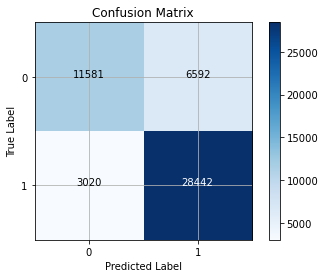

In [26]:
# Confusion matrix
plot_cf(y_test, y_hat_rf)

In [27]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:40], y=fi_df['feature_names'][:40])
    #Add chart labels
    plt.title(model_type + '', fontsize=20)
    plt.xlabel('Feature Importance', fontsize=13)
    plt.ylabel('Feature Names', fontsize=13)

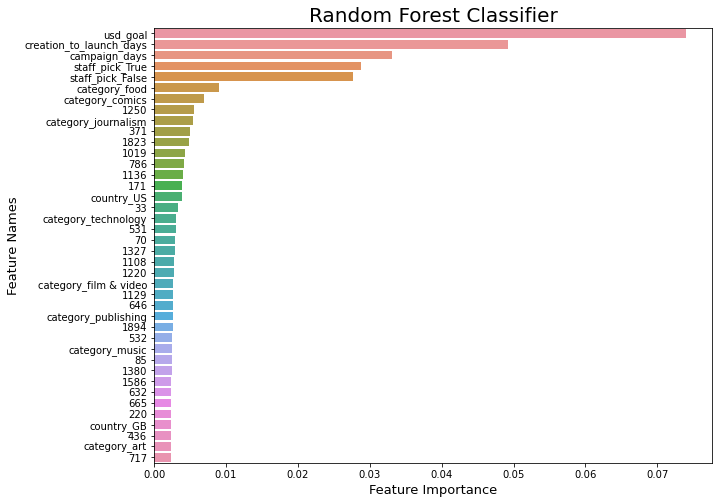

In [29]:
plot_feature_importance(rf.feature_importances_, X_all_feat.columns,'Random Forest Classifier')

In [36]:
for word, i in vectorizer.vocabulary_.items():
    if i == 1250 or i == 371 or i == 1823 or i ==1019:
        print(word)

make
want
create
pin


### random forest on nlp only

In [38]:
# Train and fit model                                                   
rf_nlp = RandomForestClassifier(random_state=1,n_jobs=-1)

rf_nlp.fit(X_train_nlp, y_train_nlp)
                                     
# Test Prediction
y_hat_rf_nlp = rf_nlp.predict(X_test_nlp)

# Printing evaluation metric (accuracy-score) 
print('Accuracy score: {:.3}'.format(rf_nlp.score(X_test_nlp, y_test_nlp)))

# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(f1_score(y_test_nlp, y_hat_rf_nlp, average = 'weighted')))

Accuracy score: 0.728
f1 score: 0.7164644287497666


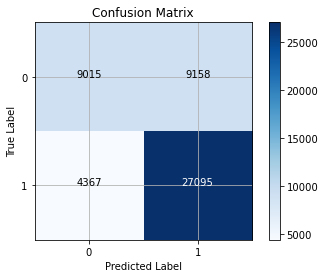

In [39]:
# Confusion matrix
plot_cf(y_test_nlp, y_hat_rf_nlp)

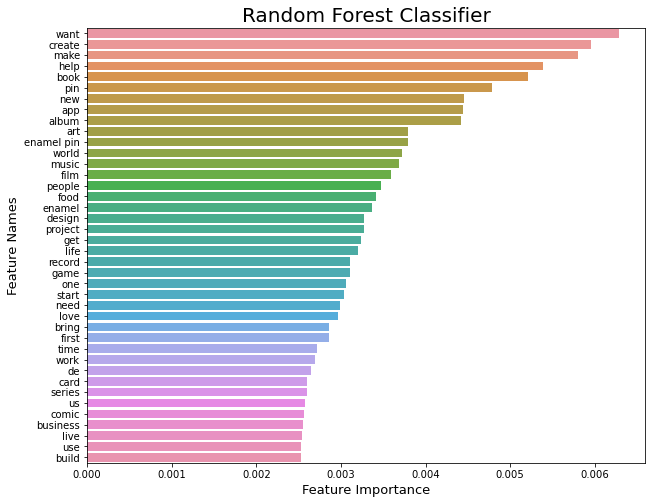

In [42]:
plot_feature_importance(rf_nlp.feature_importances_, vectorizer.get_feature_names(),'Random Forest Classifier')

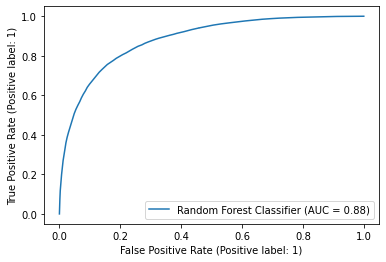

In [85]:
fig, ax = plt.subplots()
plot_roc_curve(rf, X_test, y_test, ax=ax, name='Random Forest Classifier');

### gradient boosting 

In [ ]:
# Train and fit model                                                   
gb = GradientBoostingClassifier(random_state=1)

gb.fit(X_train, y_train)
                                     
# Test Prediction
y_hat_gb = gb.predict(X_test)

# Printing evaluation metric (accuracy-score) 
print('Accuracy score: {:.3}'.format(gb.score(X_test, y_test)))

# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(f1_score(y_test, y_hat_gb, average = 'weighted')))

In [ ]:
# Confusion matrix
plot_cf(y_test, y_hat_gb)